In [1]:
from mpmath import zeta
import sympy
import matplotlib.pyplot as plt 

In [2]:
# <img src="zeta_critical_line.jpg" width="600" height="600">

**The Riemann Zeta function is defined as:**
$$\zeta(s):=\sum_{n=1}^\infty{n^{-s}} \ \ \ \ : \ (s=\sigma + it) \ \ ; \ (\sigma > 1)$$

**Computations of the Riemann Zeta function on the critical line refer to computations of the form $\zeta(\frac{1}{2} + it)$, where we move vertically along the complex plane with $t$, while being fixed at the point $\frac{1}{2}$ on the real number line. We will be using an existing implementation of the Zeta function in Python, defined in the documentation provided, http://mpmath.org/doc/current/functions/zeta.html?highlight=zeta#mpmath.zeta** 



In [3]:
N = int(1e5)   # 100000 starting value 
deltaN = 50

zeta_value = 0
real_values = [0]*deltaN
img_values = [0]*deltaN

# computing the Zeta function over a small interval defined by deltaN
for i in range(N, N+deltaN):
    point = complex(real=0.5, imag=i)
    zeta_value = zeta(point)
    
    # assign into the correct system 
    real_values[i-N] = zeta_value.real
    img_values[i-N] = zeta_value.imag

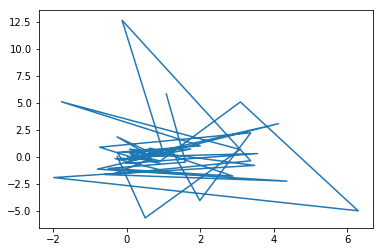

In [4]:
plt.plot(real_values, img_values)

In [5]:
import pyprimes

In [ ]:
prime_num = list(pyprimes.primes_below(1e10))

In [ ]:
prime_num